In [1]:
import findspark
findspark.init()
import pyspark
import random
from pyspark.sql.functions import *
import pyspark.sql.functions as f
import pyspark.sql.functions as pyf
import numpy as np
import pandas 
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

In [38]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from datetime import datetime
import time
import re
from ipaddress import ip_address
from urllib.parse import urlparse
import json
import isodate
from dateutil import parser
from dateutil import tz
from pyspark.sql.types import StructField, StructType, StringType
from pyspark.sql import Row
from pyspark.sql import functions as pyspark_function
from urllib.request import urlopen
import subprocess
import os.path
from os import path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [11]:

                
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext


        
spark = SparkSession \
        .builder \
        .appName("Test Spark") \
        .config("spark.jars", "/opt/postgresql-42.4.0.jar") \
        .config("spark.num.executors"," 16")  \
        .config("spark.executor.cores", "8") \
        .config("spark.executor.memory", "20g") \
        .config("spark.scheduler.mode", "FAIR") \
        .config("spark.sql.autoBroadcastJoinThreshold", -1) \
        .master("spark://131.225.58.251:7077") \
        .getOrCreate() \



#spark.conf.set("spark.executor.memory", "20g")
#spark.conf.set("spark.executor.cores", "8")

In [32]:
df = spark.read \
     .format("jdbc") \
     .option("url", "jdbc:postgresql://fndca5b:5432/billing") \
     .option("dbtable", "(select *,  split_part(storageclass, '.', 1) as vo from billinginfo where datestamp between '2022-06-01 00:00:00' and now()) as foo") \
     .option("user", "enstore_reader") \
     .option("driver", "org.postgresql.Driver") \
     .option("numPartitions", "16") \
     .option("partitionColumn", "datestamp") \
     .option("lowerBound", "2022-06-01 00:00:00") \
     .option("upperBound", "2022-06-26 23:59:59") \
     .option("fetchsize", 1000000) \
     .load()

df.printSchema()

root
 |-- client: string (nullable = true)
 |-- initiator: string (nullable = true)
 |-- isnew: boolean (nullable = true)
 |-- protocol: string (nullable = true)
 |-- transfersize: long (nullable = true)
 |-- fullsize: long (nullable = true)
 |-- storageclass: string (nullable = true)
 |-- connectiontime: long (nullable = true)
 |-- action: string (nullable = true)
 |-- cellname: string (nullable = true)
 |-- datestamp: timestamp (nullable = true)
 |-- errorcode: integer (nullable = true)
 |-- errormessage: string (nullable = true)
 |-- pnfsid: string (nullable = true)
 |-- transaction: string (nullable = true)
 |-- p2p: boolean (nullable = true)
 |-- fqan: string (nullable = true)
 |-- mappeduid: integer (nullable = true)
 |-- mappedgid: integer (nullable = true)
 |-- owner: string (nullable = true)
 |-- vo: string (nullable = true)



In [39]:
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,client,string
1,initiator,string
2,isnew,boolean
3,protocol,string
4,transfersize,bigint
5,fullsize,bigint
6,storageclass,string
7,connectiontime,bigint
8,action,string
9,cellname,string


In [33]:
t0 = time.time()
print("Number of entries is    =====> ", df.count(), " Time to execute ", time.time()-t0)

Number of entries is    =====>  149402080  Time to execute  127.60640096664429


In [16]:
df.createOrReplaceTempView("billing")
df.cache()
print("Number of entries again =====> ", df.count(), " Time to execute ", time.time()-t0)

Number of entries again =====>  149215218  Time to execute  1050.4104778766632


In [42]:
df_uniq_storageclass = spark.sql("SELECT DISTINCT(storageclass),COUNT(storageclass) FROM billing GROUP BY storageclass")
df_uniq_storageclass.show()

+--------------------+-------------------+
|        storageclass|count(storageclass)|
+--------------------+-------------------+
|GM2.gm2_5126A@ens...|             197000|
|minerva.mc_recons...|             285807|
|nova.persistent@e...|           28319213|
|uboone.overlay_tu...|            1163034|
|nova.raw2root_fd_...|              44424|
|nova.raw2root_fd_...|              15382|
|e906.persistent@e...|             101554|
| test.dcache@enstore|               2709|
|dune.hd-coldbox-2...|               8545|
|lariat.scratch@en...|                700|
|dune.dune-fardet-...|              37958|
|mars.resilient@en...|             444503|
|dune.protodune-sp...|             289231|
|nova.pid_sim_fd@e...|              25458|
|next.persistent@e...|               6160|
|nova.cosfilt_numi...|               9474|
|e1039.persistent@...|              14092|
|minos.persistent@...|              25345|
|sbnd.persistent@e...|            1902291|
|dune.protodune-sp...|              74919|
+----------

In [22]:
storage_class = "GM2.scratch@enstore"
sql_query = f"select cellname from billing where storageclass='{storage_class}' order by cellname"
pools = spark.sql(sql_query).collect()
uniq_pools = spark.sql(f"select distinct(cellname) from billing  where storageclass='{storage_class}' order by cellname").collect()

In [29]:
#print(uniq_pools)

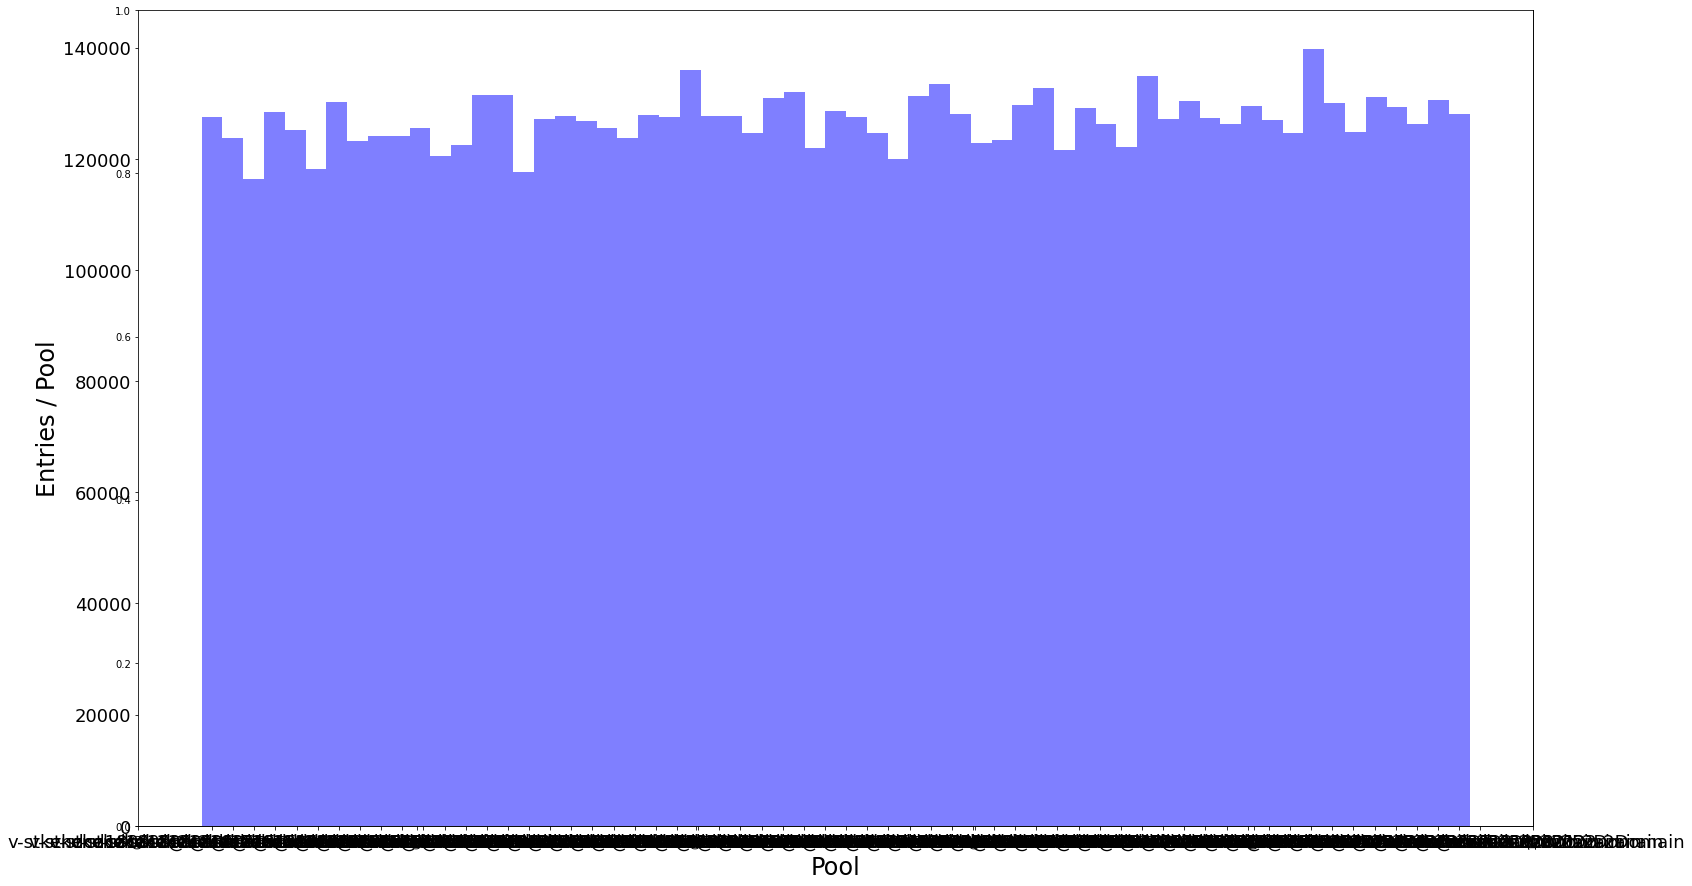

In [23]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(25, 15), dpi=72, facecolor='w')
plt.xticks(rotation=90)
plot = fig.add_subplot(111)
num_bins = len(uniq_pools)
pool_array = np.array(pools)
n, bins, patches = plot.hist(pool_array, num_bins, facecolor='blue', alpha=0.5, align='left',rwidth=1.0)
plt.ylabel('Entries / Pool',fontsize=24)
plt.xlabel('Pool',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [24]:
sql_query = f"select distinct(cellname),SUM(transfersize/1024./1024./1024./1024.) OVER(PARTITION BY cellname) AS Bytes from billing where storageclass='{storage_class}' order by cellname"
write_per_pool = spark.sql(sql_query)
write_per_pool.show()

+--------------------+--------------------+
|            cellname|               Bytes|
+--------------------+--------------------+
|v-stkendca1806-1@...|15.54947172240092...|
|v-stkendca1806-2@...|14.19709753169312...|
|v-stkendca1806-3@...|14.26477817178174...|
|v-stkendca1806-4@...|15.63848373957617...|
|v-stkendca1806-5@...|16.25227787528121...|
|v-stkendca1806-6@...|13.76150699261942...|
|v-stkendca1815-1@...|16.33106598886532...|
|v-stkendca1815-2@...|16.16696485328004...|
|v-stkendca1815-3@...|14.99934778422281...|
|v-stkendca1815-4@...|15.69977652264007...|
|v-stkendca1815-5@...|15.40248542199137...|
|v-stkendca1815-6@...|16.21890321862700...|
|v-stkendca1816-1@...|16.06319823515072...|
|v-stkendca1816-2@...|16.60421362739837...|
|v-stkendca1816-3@...|15.43606774405810...|
|v-stkendca1816-4@...|16.38227400432984...|
|v-stkendca1816-5@...|16.28351107166657...|
|v-stkendca1816-6@...|16.68605844066713...|
|v-stkendca1901-3@...|16.95842050777277...|
|v-stkendca1903-3@...|17.0733035

In [25]:
pools_array = write_per_pool.rdd.map(lambda row: row[0]).collect()
size_array  = write_per_pool.rdd.map(lambda row: row[1]).collect()

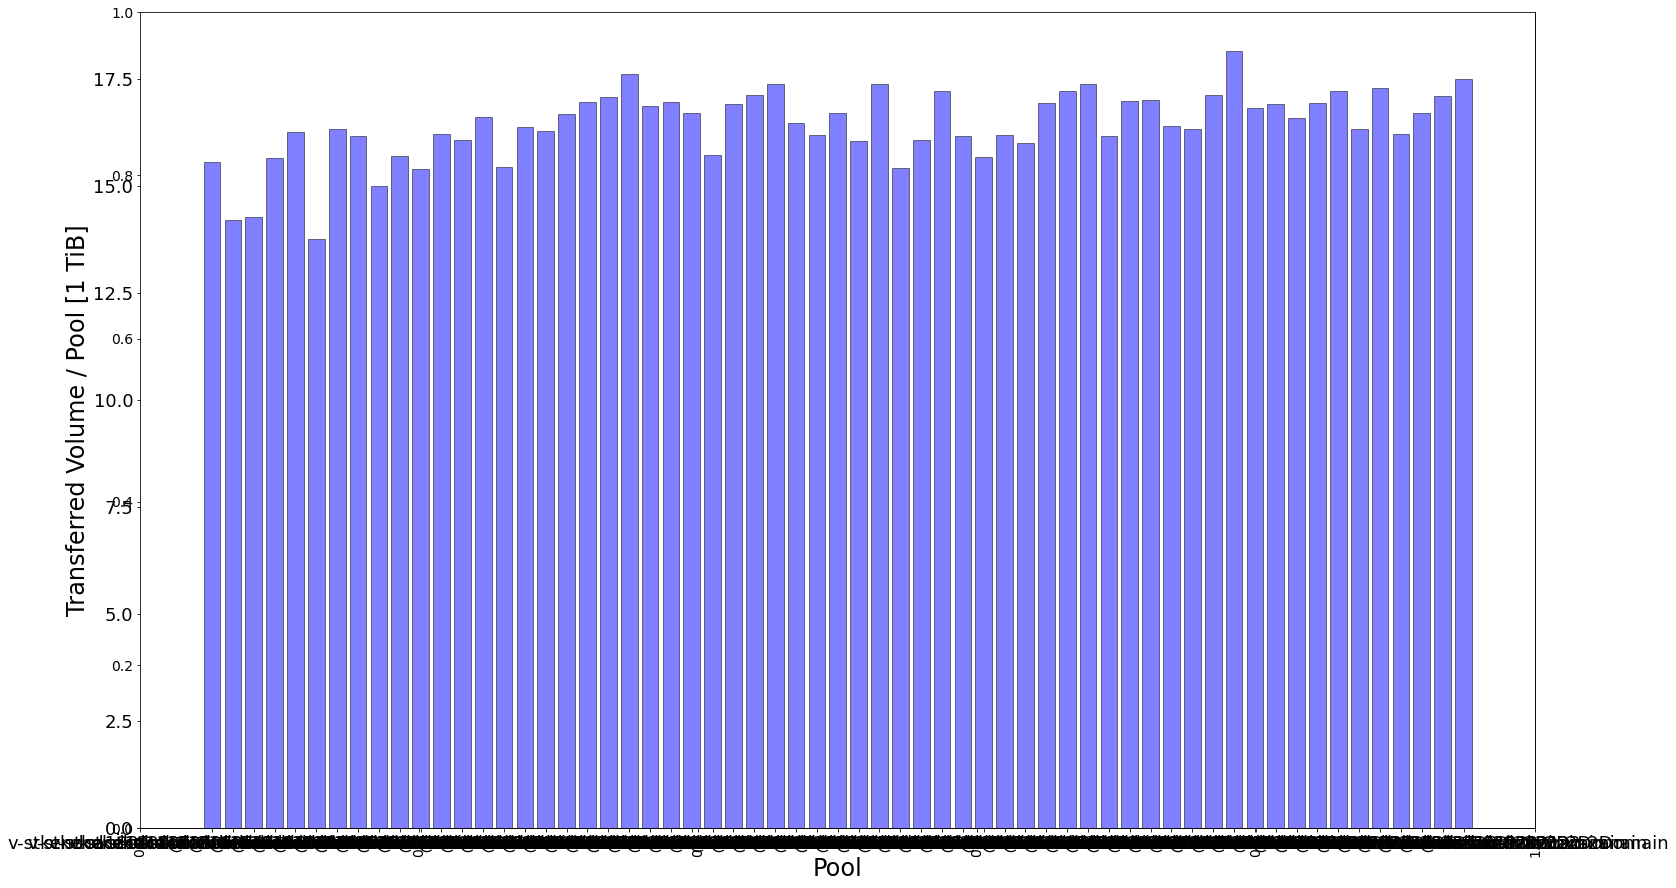

In [26]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(25, 15), dpi=72, facecolor='w')
plt.xticks(rotation=90)
plot = fig.add_subplot(111)
plot.bar(pools_array, size_array, color='blue',edgecolor = 'black', alpha=0.5)
plt.ylabel('Transferred Volume / Pool [1 TiB]',fontsize=24)
plt.xlabel('Pool',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()